# SHAP and Shapley using Taiwan Credit Default data

## Exploratory Data Analysis

In [103]:
# Import Libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True) 
import plotly.graph_objs as go 
import plotly.tools as tls 
from collections import Counter

In [2]:
import random
random.seed(10)
print(random.random())  # 0.571402

0.5714025946899135


In [3]:
# Read the data 
taiwan = pd.read_csv('taiwan_credit_defaults.csv')

In [4]:
# Short clean
taiwan.rename(columns = {'PAY_0':'PAY_1'}, inplace = True)  # Rename columns for more consistent analysis
taiwan.rename(columns = {'default payment next month':'default_payment_next_month'}, inplace = True)
taiwan = taiwan.drop('ID', 1)  # Remove the ID column which is just a numeric from 1 to 30,000

### Basic Information

Here, we are just looking at the size of the data set, features, null values, data types, and number of unique values for each feature

In [5]:
taiwan.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
taiwan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_1                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

**Information regarding each attribute:**
- Begins April 2005 through September 2005
- LIMIT_BAL is amount of given credit
- SEX (1 is Male, 2 is Female)
- EDUCATION (1 = Graduate School, 2 = University, 3 = High School, 4 = Other)
- MARRIAGE (1 = Married, 2 = Single, 3 = Other)
- AGE
- PAY_1 through PAY_6: History of past payment results (-1 = pay duly, 1 = payment delay for one month; 2 = payment delay for two months...)
- BILL_AMT1 through BILL_AMT6: Amount of bill statement (BILL_AMT1 = September bill, BILL_AMT2 = August bill, etc.)
- PAY_AMT1 through PAY_AMT6: Amount paid (PAY_AMT1 = September paid amount, PAY_AMT2 = August paid amount, etc.)
- default_payment_next_month: Binary variable (1 = Defaulted, 0 = Not Defaulted)

In [7]:
taiwan.isnull().sum().sort_values(ascending=False)

LIMIT_BAL                     0
SEX                           0
PAY_AMT6                      0
PAY_AMT5                      0
PAY_AMT4                      0
PAY_AMT3                      0
PAY_AMT2                      0
PAY_AMT1                      0
BILL_AMT6                     0
BILL_AMT5                     0
BILL_AMT4                     0
BILL_AMT3                     0
BILL_AMT2                     0
BILL_AMT1                     0
PAY_6                         0
PAY_5                         0
PAY_4                         0
PAY_3                         0
PAY_2                         0
PAY_1                         0
AGE                           0
MARRIAGE                      0
EDUCATION                     0
default_payment_next_month    0
dtype: int64

### Distributional Analysis

I look at the distributions of different features to see whether there are any biases among different subsets of the data

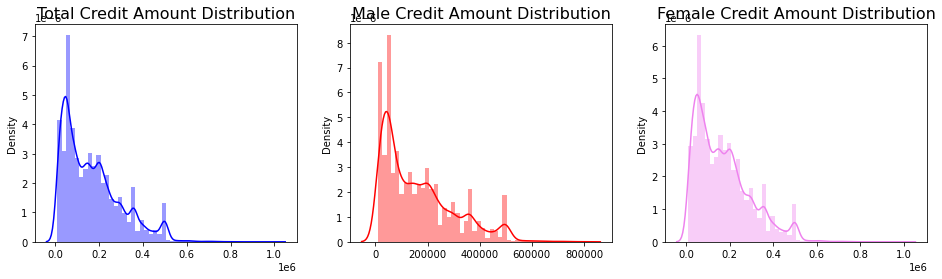

In [8]:
overall_credit = taiwan['LIMIT_BAL'].values  # Total credit amounts
male_credit = taiwan[taiwan['SEX'] == 1]['LIMIT_BAL'].values  # Credit amounts of male
female_credit = taiwan[taiwan['SEX'] == 2]['LIMIT_BAL'].values  # Credit amounts of female

fig, ax = plt.subplots(1, 3, figsize=(16,4))  # Define subplots - 1 row 3 column
sns.distplot(overall_credit, ax=ax[0], color= 'blue')
ax[0].set_title("Total Credit Amount Distribution", fontsize=16)  # Distribution plot of total credit amounts
sns.distplot(male_credit, ax=ax[1], color="red")  # Distribution plot of male credit amounts
ax[1].set_title("Male Credit Amount Distribution", fontsize=16)
sns.distplot(female_credit, ax=ax[2], color="violet")  # Distribution plot of female credit amounts
ax[2].set_title("Female Credit Amount Distribution", fontsize=16)
plt.show()

Seems like the data is evenly distributed among males and females. Males do on average receive more credit - careful with the axes! Axes are not evenly matched.

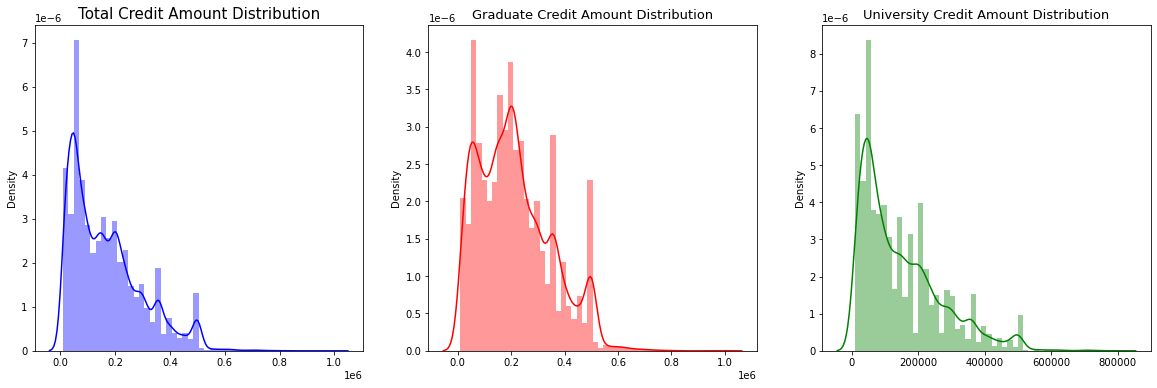

In [9]:
overall_credit = taiwan['LIMIT_BAL'].values  # Total credit amounts
graduate = taiwan[taiwan['EDUCATION'] == 1]['LIMIT_BAL'].values  # Credit amounts of graduate education
university = taiwan[taiwan['EDUCATION'] == 2]['LIMIT_BAL'].values  # Credit amounts of university education
high_school = taiwan[taiwan['EDUCATION'] == 3]['LIMIT_BAL'].values  # Credit amounts of high school education
other = taiwan[taiwan['EDUCATION'] == 4]['LIMIT_BAL'].values  # Credit amounts of other education

fig, ax = plt.subplots(1, 3, figsize=(20,6))  # Define subplots - 1 row 4 column
sns.distplot(overall_credit, ax=ax[0], color= 'blue')  # Distribution plot of total credit amounts
ax[0].set_title("Total Credit Amount Distribution", fontsize=15) 
sns.distplot(graduate, ax=ax[1], color="red")  # Distribution plot of Graduate credit amounts
ax[1].set_title("Graduate Credit Amount Distribution", fontsize=13)
sns.distplot(university, ax=ax[2], color="green")  # Distribution plot of University credit amounts
ax[2].set_title("University Credit Amount Distribution", fontsize=13)
plt.show()

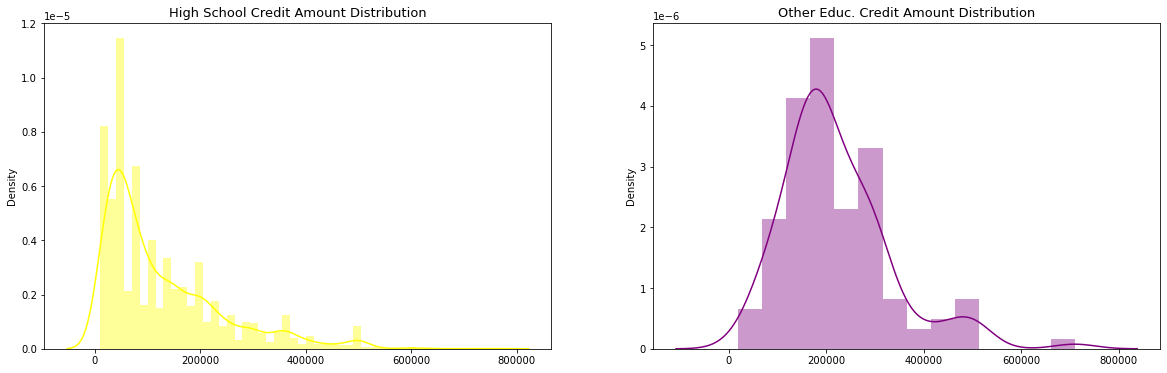

In [10]:
overall_credit = taiwan['LIMIT_BAL'].values  # Total credit amounts
graduate = taiwan[taiwan['EDUCATION'] == 1]['LIMIT_BAL'].values  # Credit amounts of graduate education
university = taiwan[taiwan['EDUCATION'] == 2]['LIMIT_BAL'].values  # Credit amounts of university education
high_school = taiwan[taiwan['EDUCATION'] == 3]['LIMIT_BAL'].values  # Credit amounts of high school education
other = taiwan[taiwan['EDUCATION'] == 4]['LIMIT_BAL'].values  # Credit amounts of other education

fig, ax = plt.subplots(1, 2, figsize=(20,6))  # Define subplots - 1 row 4 column
sns.distplot(high_school, ax=ax[0], color="yellow")  # Distribution plot of High School credit amounts
ax[0].set_title("High School Credit Amount Distribution", fontsize=13)
sns.distplot(other, ax=ax[1], color="purple")  # Distribution plot of Other Educ. credit amounts
ax[1].set_title("Other Educ. Credit Amount Distribution", fontsize=13)
plt.show()

In [11]:
avg_credit_graduate = np.median(graduate)
avg_credit_university = np.median(university)
avg_credit_high_school = np.median(high_school)

print(f"Median credit received for a person with a graduate degree is {avg_credit_graduate}")
print(f"Median credit received for a person with a university degree is {avg_credit_university}")
print(f"Median credit received for a person with a high school degree is {avg_credit_high_school}")

Median credit received for a person with a graduate degree is 200000.0
Median credit received for a person with a university degree is 110000.0
Median credit received for a person with a high school degree is 80000.0


People with a graduate degree are typically able to receive much higher lines of credit than those with a university or high school degree. 

### Target Variable Distribution

We can see whether the target variable distribution is balanced

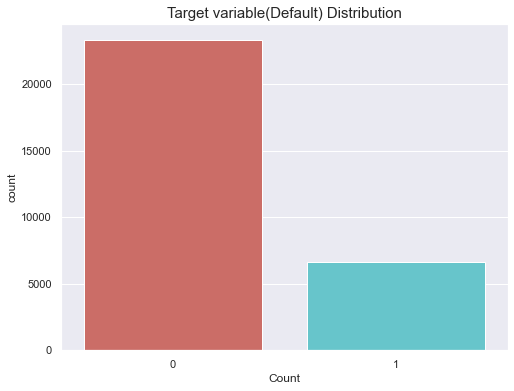

In [12]:
sns.set(rc = {'figure.figsize':(8,6)})
g1 = sns.countplot(x="default_payment_next_month",data= taiwan, palette="hls")                  
g1.set_title("Target variable(Default) Distribution", fontsize=15)
g1.set_xlabel("Default")
g1.set_xlabel("Count")
plt.show()

As we can see, not defaulting occurs at a rate 4 times as often as defaulting does. While we do not have a balanced data set, there are enough counts in each case where we can continue with our analysis

### Distribution of age among people who defaulted/not defaulted

In [13]:
df_default = taiwan.loc[taiwan["default_payment_next_month"] == 1]['AGE'].values.tolist()  # Age of people who defaulted
df_not_default = taiwan.loc[taiwan["default_payment_next_month"] == 0]['AGE'].values.tolist()  # Age of people who didn't default
df_age = taiwan['AGE'].values.tolist()

# Age distribution of people who defaulted
trace0 = go.Histogram(
    x=df_default,
    histnorm='probability',
    name="Defaulted"
)
# Age distribution of people who did not default
trace1 = go.Histogram(
    x=df_not_default,
    histnorm='probability',
    name="Not Defaulted"
)
# Age distribution of people in the dataset
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Defaulted','Not Defaulted', 'Overall Age Distribuition'))

#Setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribution', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

/Users/Ivan/opt/anaconda3/lib/python3.9/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### Distribution of sex among people who defaulted/not defaulted

In [14]:
df_default_sex = taiwan.loc[taiwan["default_payment_next_month"] == 1]['SEX'].values.tolist()  # Sex of people who defaulted
df_not_default_sex = taiwan.loc[taiwan["default_payment_next_month"] == 0]['SEX'].values.tolist()  # Sex of people who didn't default
df_sex = taiwan['SEX'].values.tolist()

# Age distribution of people who defaulted
trace0 = go.Histogram(
    x=df_default_sex,
    histnorm='probability',
    name="Defaulted"
)
# Age distribution of people who did not default
trace1 = go.Histogram(
    x=df_not_default_sex,
    histnorm='probability',
    name="Not Defaulted"
)
# Age distribution of people in the dataset
trace2 = go.Histogram(
    x=df_sex,
    histnorm='probability',
    name="Overall Sex"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Defaulted','Not Defaulted', 'Overall Sex Distribuition'))

#Setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Sex Distribution', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

/Users/Ivan/opt/anaconda3/lib/python3.9/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Here, we can see there is a bigger gap between the sexes in the 'Not Defaulted' category.

All seem to be the same age, yields consistent results.

### Regression Plots

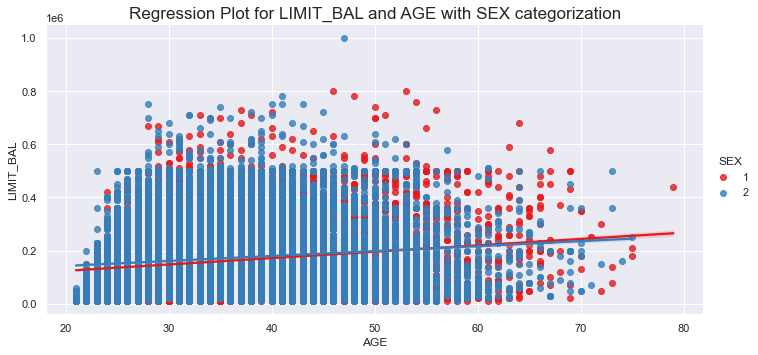

In [15]:
sns.lmplot(x="AGE",y="LIMIT_BAL", hue="SEX", data=taiwan, palette="Set1", aspect=2) # Linear relationship between credit amount and age variables with sex seperation
plt.title('Regression Plot for LIMIT_BAL and AGE with SEX categorization', fontsize=17)
plt.show()

As age goes up, limit balance also has a positive trend. Sex does not seem to change (in terms of slope) among people's given credit amount.

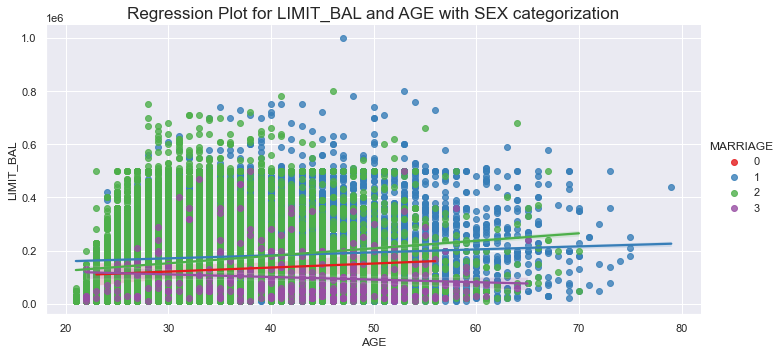

In [16]:
sns.lmplot(x="AGE",y="LIMIT_BAL", hue="MARRIAGE", data=taiwan, palette="Set1", aspect=2) # Linear relationship between credit amount and age variables with marriage seperation
plt.title('Regression Plot for LIMIT_BAL and AGE with SEX categorization', fontsize=17)
plt.show()

The 'other' category in the marriage feature seems to display a negative slope in limit balance, with respect to age. 

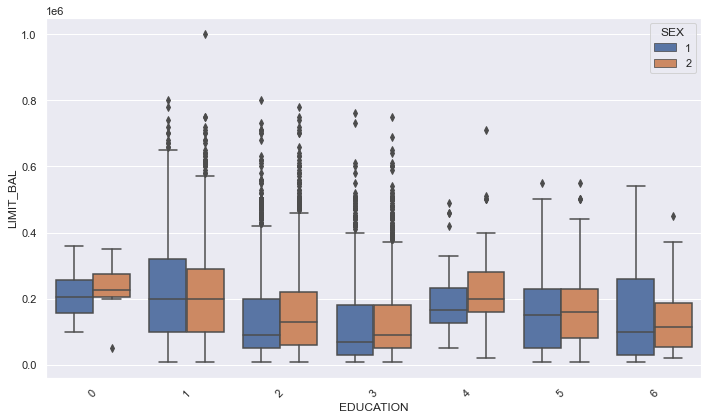

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
box = sns.boxplot(x= 'EDUCATION',y= 'LIMIT_BAL', hue= 'SEX', data=taiwan) # Distribution of credit amount across purpose feature with Sex categorization
box.set_xticklabels(box.get_xticklabels(), rotation= 45) # Properties like minimum, first quartile, median, third quartile, maximum and outliers can be detected
fig.subplots_adjust(bottom=0.2)
plt.tight_layout()

Seems like females on average obtain larger credit amounts. 

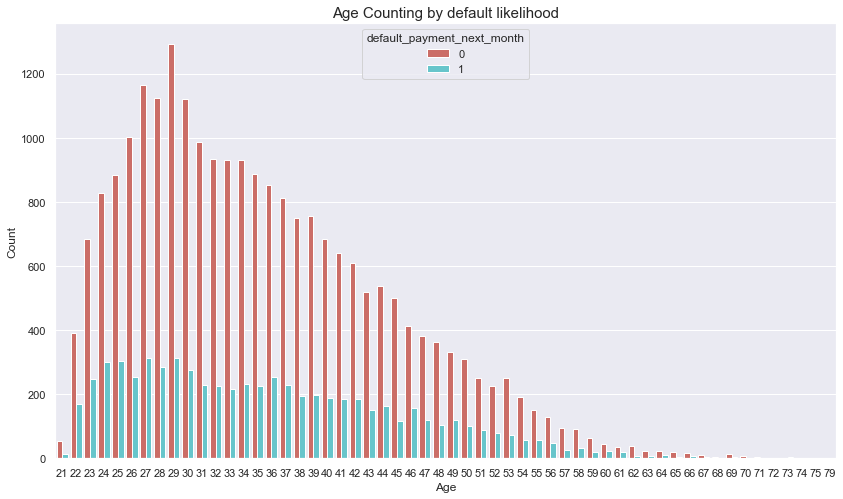

In [18]:
sns.set(rc = {'figure.figsize':(14,8)})
g2 = sns.countplot(x="AGE",data= taiwan,  # Histogram across age feature with risk categorization
              palette="hls", 
              hue = "default_payment_next_month")
g2.set_title("Age Counting by default likelihood", fontsize=15)
g2.set_xlabel("Age")
g2.set_ylabel("Count")
plt.show()

The following count plot shows the distribution across age of entries who default payment next month. Younger age means much higher risk of defaulting in the next month.

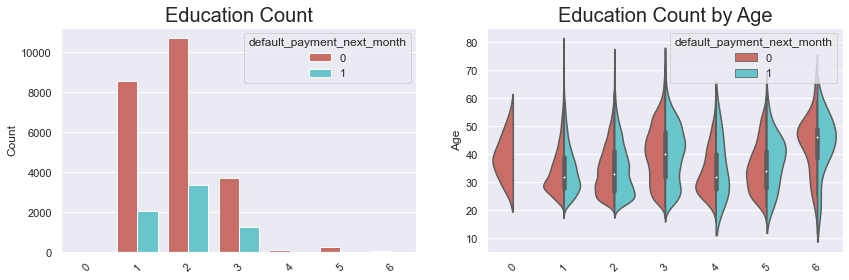

In [19]:
plt.figure(figsize = (14,12))

# Histogram across purposes with risk categorization
plt.subplot(221)             
g = sns.countplot(x="EDUCATION", data= taiwan, 
              palette="hls", hue = "default_payment_next_month")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Education Count", fontsize=20)

# Distribution of age across purposes with risk categorization
plt.subplot(222)             
g1 = sns.violinplot(x="EDUCATION", y="AGE", data= taiwan, 
                    palette="hls", hue = "default_payment_next_month",split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Age", fontsize=12)
g1.set_title("Education Count by Age", fontsize=20)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

Interestingly enough, it seems like university graduates are more likely to default on payments than high school graduates. 

## Fitting a complex model
Now that we have performed a preliminary data analysis as a benchmark, we can fit a complex model in order to predict whether a new person will likely default in the next month. In this case, we will use a neural network to make the prediction.

In [20]:
import sklearn
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense


# matplotlib.use('TkAgg')  # to open pictures in new window, currently saving them
import matplotlib.image as pltimg
from matplotlib.colors import ListedColormap

import sklearn.neural_network
from sklearn.model_selection import train_test_split # split the data into training and testing
from sklearn.preprocessing import scale # scale and center data
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [21]:
features = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 
            'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
X = taiwan[features].values

y = taiwan['default_payment_next_month'].values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.5)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [23]:
neural_network_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(23,)),
    keras.layers.Dense(2, activation=tf.nn.sigmoid),
    keras.layers.Dense(1),
])

2022-06-08 22:55:39.036829: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Neural Network with an input layer with 23 dimensions, 3 neurons, and output layer of 1 neuron.

In [24]:
neural_network_model.compile(optimizer='adam', loss='log_cosh', metrics=['accuracy'])

In [25]:
neural_network_hist = neural_network_model.fit(X_train_scaled, y_train, epochs=50, batch_size=30)

Epoch 1/50
500/500 [==============================] - 1s 2ms/step - loss: 0.1303 - accuracy: 0.7759
Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0749 - accuracy: 0.7899
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0721 - accuracy: 0.7953
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0714 - accuracy: 0.7956
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0711 - accuracy: 0.7969
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0710 - accuracy: 0.7975
Epoch 7/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0708 - accuracy: 0.7967
Epoch 8/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0706 - accuracy: 0.7991
Epoch 9/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0704 - accuracy: 0.7995
Epoch 10/50
500/500 [==============================] - 1s 2ms/step - loss: 0.0702 - accuracy: 0.7998

Testing different amounts of neurons, loss functions, and activation functions has led to this architecture for the neural network to perform best.

In [26]:
neural_network_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 23)                0         
                                                                 
 dense (Dense)               (None, 2)                 48        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


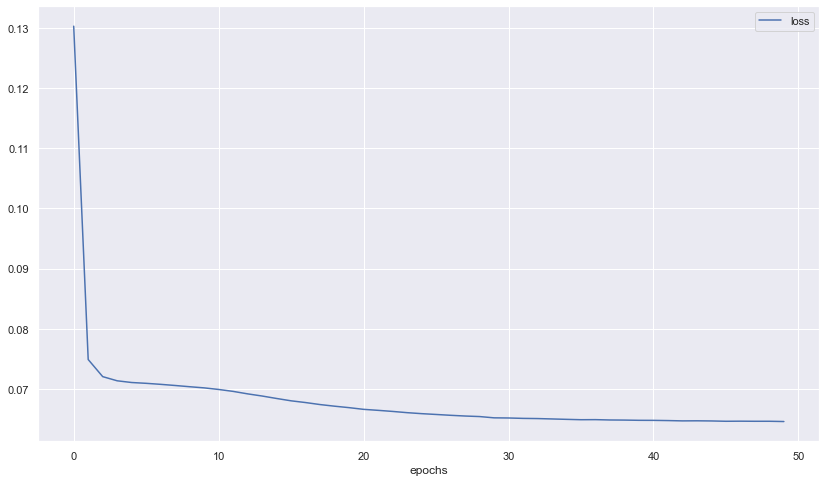

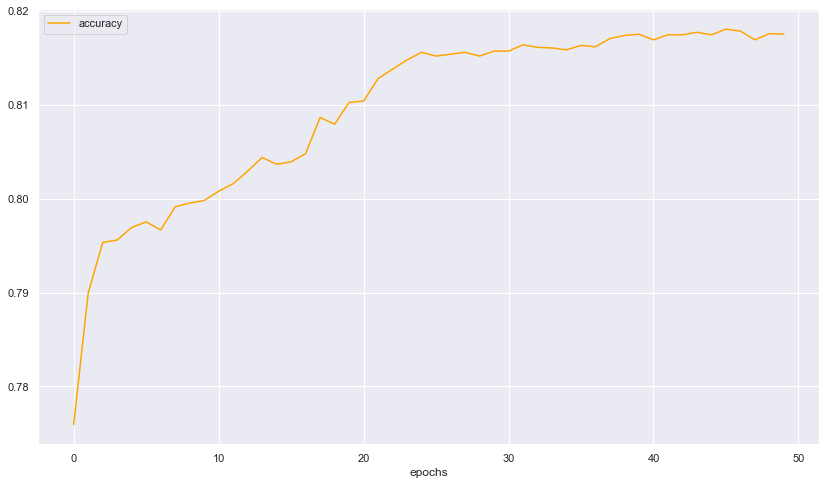

In [27]:
# Showing plot for loss
plt.plot(neural_network_hist.history['loss'])
plt.xlabel('epochs')
plt.legend(['loss'])
plt.show()
 
# Showing plot for accuracy
plt.plot(neural_network_hist.history['accuracy'], color='orange')
plt.xlabel('epochs')
plt.legend(['accuracy'])
plt.show()

In [28]:
# Call evaluate to find the accuracy on test
test_loss, test_accuracy = neural_network_model.evaluate(
  x = X_test_scaled, 
  y = y_test
)
 
print("Test Loss: %.4f"%test_loss)
print("Test Accuracy: %.4f"%test_accuracy)

469/469 [==============================] - 1s 1ms/step - loss: 0.0636 - accuracy: 0.8215
Test Loss: 0.0636
Test Accuracy: 0.8215


In [29]:
raw_y_pred = neural_network_model.predict(X_test_scaled)

We have probabilities for the predicted values, so we need to convert them into binary values

In [30]:
def postprocessing(array):
    temp = array.flatten()
    temp_list = temp.tolist()
    end_list = []
    for i in temp_list:
        if i < 0.5:
            end_list.append(0)
        else:
            end_list.append(1)
    arr = np.array(end_list)
    return arr
    

In [31]:
y_pred = postprocessing(raw_y_pred)

In [32]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[11103   622]
 [ 2056  1219]]


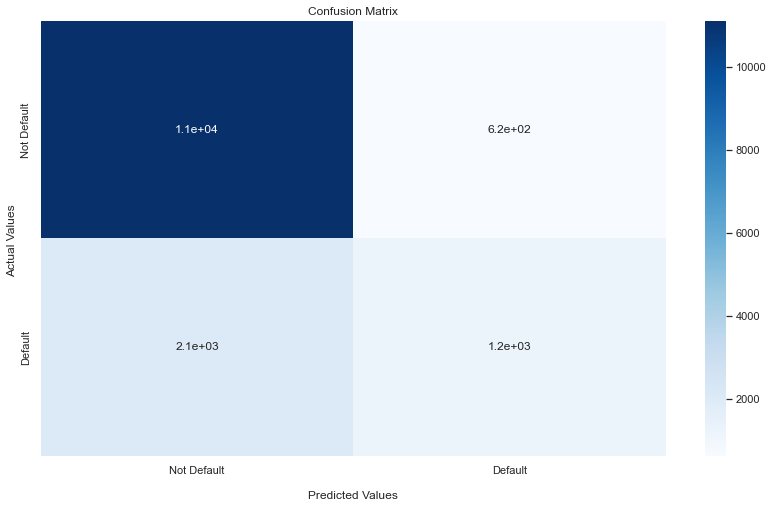

In [33]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Not Default','Default'])
ax.yaxis.set_ticklabels(['Not Default','Default'])

## Display the visualization of the Confusion Matrix.
plt.show()

In the end, we obtained a reasonable neural network model, but in terms of interpretation, we are not able to do much. If we wanted to know what the effect of each feature was on the neural network, or how much weight is placed on each feature, it would be much trickier to evaluate.

## Using SHAP and Shapley values on the neural network

In [34]:
!pip install shap

You should consider upgrading via the '/Users/Ivan/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [35]:
import shap

In [104]:
# init the JS visualization code
shap.initjs()

The biggest problem with SHAP is the computation time. Here we will make a temporary variable that will only include the first 100 values of X_train

In [41]:
short_X_train = shap.sample(X_train_scaled, 100)
short_X_test = shap.sample(X_test_scaled, 100)

In [42]:
explainer = shap.KernelExplainer(neural_network_model.predict,short_X_train)

In [43]:
shap_values = explainer.shap_values(short_X_test,nsamples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Below we can show a graph for how much each feature contributes to the outcome of the model. 

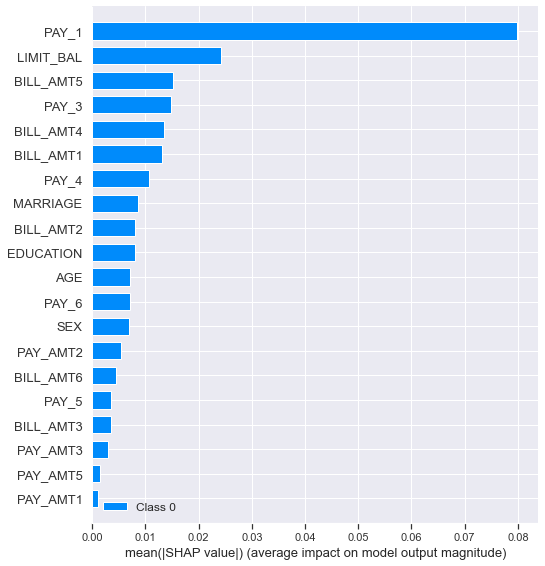

In [44]:
shap.summary_plot(shap_values,short_X_test,feature_names=features)

Here, we can see that whether or not someone paid duly the previous month is the largest indicator for whether or not the person will default in the upcoming month. This is then followed by factors such as how much credit they are given as well as whether or not the person is married. Least contributors in this model include the amount the person paid last month as well as whether or not they paid duly 5 months prior.

Below we find explanations for the entire dataset. For each point, we can see how much a single feature contributes to the output variable f(x). f(x) in this case is whether or not a person will default.

In [105]:
shap.plots.force(explainer.expected_value, shap_values[0], feature_names = features)

Unfortunately, the neural network does predict negative values for our output which does not make much sense. I was unable to find a better model than sequential() which classifies output as binary.

So unfortunately, the SHAP values are NOT optimized for neural network explanation. We can do better by comparing these results with a tree based method. In our case, we will use LightGBM, a gradient boosting method in order to compare our results and see if we obtain consistent values.

In [53]:
import lightgbm as lgb

In [61]:
len(y)

30000

In [62]:
X_df = taiwan.drop('default_payment_next_month', axis=1).copy()
len(X_df)

# create a train/test split
X_train_gbm, X_test_gbm, y_train_gbm, y_test_gbm = train_test_split(X_df, y, test_size=0.2, random_state=42)
d_train = lgb.Dataset(X_train_gbm, label=y_train_gbm)
d_test = lgb.Dataset(X_test_gbm, label=y_test_gbm)

In [83]:
X_train_gbm

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
21753,80000,2,2,2,24,0,0,0,0,0,...,78321,73731,39643,39457,3503,5001,2092,1218,1445,878
251,30000,1,2,2,28,0,0,0,0,0,...,29155,25255,22001,0,5006,1244,851,955,0,0
22941,180000,2,5,1,44,0,0,-1,-1,-1,...,850,0,6881,10340,0,850,0,6881,10340,182
618,60000,1,1,2,25,0,0,0,0,0,...,38533,39639,39619,39140,2018,1900,2000,1500,1900,2000
17090,130000,2,2,2,25,0,0,0,0,0,...,114734,117823,120854,123904,4100,4200,5000,5000,5000,10700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,50000,1,2,2,32,0,0,0,0,0,...,55739,55957,29238,6119,2000,3000,1591,72,1134,73421
5390,200000,1,1,2,37,2,2,2,2,2,...,168386,164182,169029,172084,13500,6000,0,7500,6000,4000
860,50000,1,1,2,26,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
15795,70000,2,2,2,25,0,0,0,0,2,...,51152,35122,28633,28039,3000,2000,4500,1200,0,1200


In [63]:
d_train = lgb.Dataset(X_train_gbm, label=y_train_gbm)
d_test = lgb.Dataset(X_test_gbm, label=y_test_gbm)

In [111]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

gbm_model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 0.423874


Here we can now explain our predictions

In [68]:
short_X_train_gbm = shap.sample(X_train_gbm, 100)
short_X_test_gbm = shap.sample(X_test_gbm, 100)

In [69]:
gbm_explainer = shap.TreeExplainer(gbm_model)
gbm_shap_values = explainer.shap_values(short_X_train_gbm)

  0%|          | 0/100 [00:00<?, ?it/s]

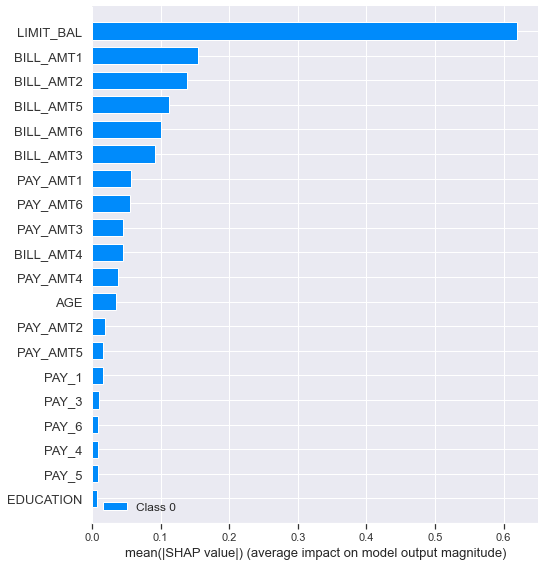

In [112]:
shap.summary_plot(gbm_shap_values, X_test_gbm,feature_names=features)

In [106]:
shap.force_plot(gbm_explainer.expected_value[0], gbm_shap_values[0][0,:], X_df.iloc[0,:])

Here, we can see for this specific person, the main determinants are bill_amt1, bill_amt2, and limit_bal

To visualize many predictions, we have

In [113]:
shap.force_plot(gbm_explainer.expected_value[0], gbm_shap_values[0][:1000,:], X_df.iloc[:1000,:])

#### Shap Summary Plot

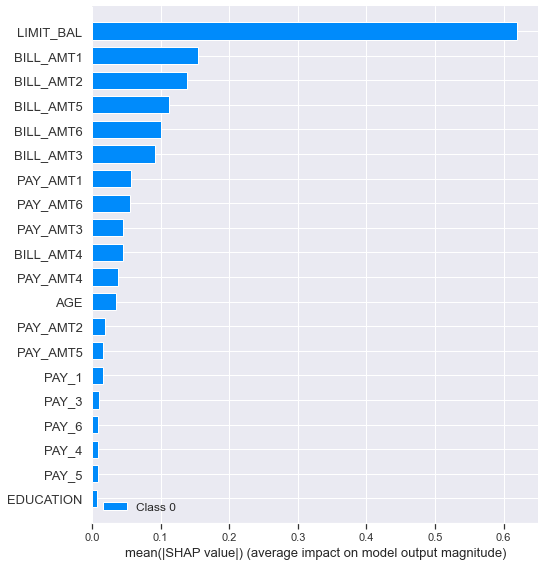

In [85]:
shap.summary_plot(gbm_shap_values, X_df)

#### Training a model with two leaves per tree and hence no interaction among them.

In [90]:
params = {
    "max_bin": 512,
    "learning_rate": 0.1,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 2,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model_ind = lgb.train(params, d_train, 20000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[920]	valid_0's binary_logloss: 0.429718


In [91]:
shap_values_ind = shap.TreeExplainer(model_ind).shap_values(X_df)

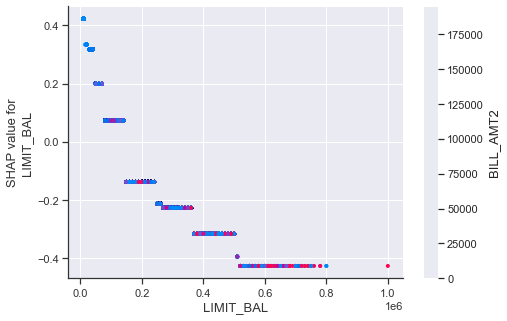

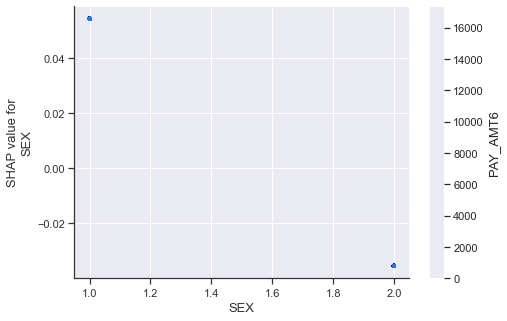

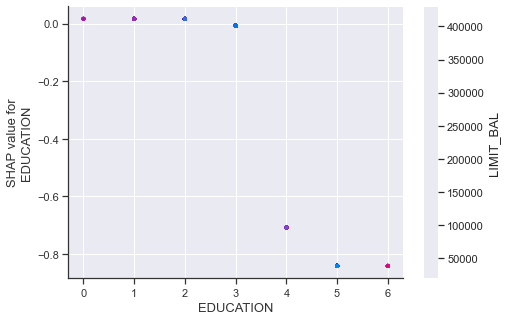

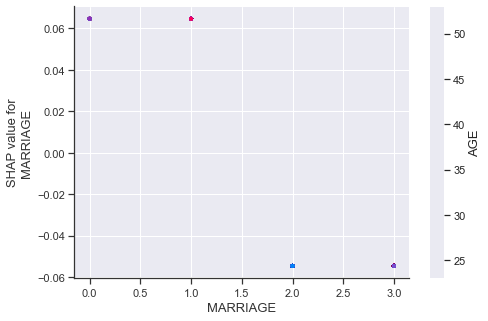

ValueError: Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.

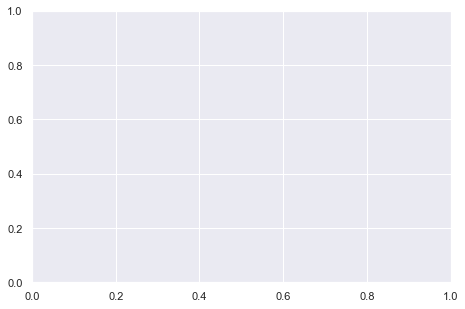

In [97]:
for name in X_df.columns:
    shap.dependence_plot(name, shap_values_ind[1], X_df)

Here, we get some errors but that is only because of some feature characteristics. If we look at limit_bal, we can see that the SHAP values actually get smaller as the balance gets larger. So if we are alloted more money, then the role that plays in whether you default next month gets smaller. SHAP values for education are also about equal for the amount of education a person receives. If a person is married (value=1), then it plays a much higher role than if the person was single(value=2). 